In [1]:
from project_lib import *
import tqdm

In [2]:
df = pd.read_csv('dataset_tmc.csv', parse_dates = ['Dates'], date_format = '%d/%m/%y')
df.columns = [i.lower() for i in df.columns]
df.columns = [i.replace(' ','_') for i in df.columns]
df = df.set_index('dates')

# Check NaNs
if df.isna().sum().sum() != 0:
    print('check NaNs in data')

# Drop Sat&Sun if any
df = df[df.index.dayofweek<5]

In [4]:
# STRATEGY PARAMETERS
TRADED_SECURITIES = [
            'us_staples', 'eu_healthcare', 'japan', 'brazil', 'nasdaq', 'us_2y',
            'us_15y', 'germany_10y', 'uk_15y', 'us_hy', 'oil', 'ind_metals', 'agri',
            'gold', 'silver', 'eurusd', 'usdjpy', 'chfjpy', 'eurbrl', 'gbpmxn'
    ]

LONG_PARAMS = {10:0.05, 21:0.15, 63:0.25} # dict with lenght of window as key and percentile for longs as values
SHORT_PARAMS = {10:0.95, 21:0.85, 63:0.75} # dict with lenght of window as key and percentile for shorts as values
MA_FAST_WDW = 20
MA_SLOW_WDW = 60

SUPPORTIVE_PCTL_MOVE = 0.3
COUNTER_PCTL_MOVE = 0.2
TRADES_MAX_DAYS = 21

MAX_DOLLAR_LOSS = 100


In [5]:
# list to store all trades
trades_list = []
trades_pnl = {}

for security_id in tqdm.tqdm(TRADED_SECURITIES):
    # generate signal based on standard strategy
    signal_all = meanrev_signal(df[security_id],
                                long_params = LONG_PARAMS,
                                short_params = SHORT_PARAMS,
                                ma_fast_wdw = MA_FAST_WDW,
                                ma_slow_wdw = MA_SLOW_WDW
                )

    # "start your backtest at t-10". hard coding initial date
    signal_all = signal_all.loc['2014-02-12':]

    # extract from all signal only the actual open buy/sell triggers
    signal_do = signal_all[signal_all!= 0]

    # iterates over all buy/sell signal and execute orders
    for dt_open, direction in zip(signal_do.index, signal_do):
        
        # create a unique id for each trade
        trade_id = security_id+'#'+str(dt_open)[:10]

        # price at which the trade is open
        price_open = df.loc[dt_open, security_id]

        # compute TP/SL returns and prices
        tp_return, sl_return = tp_sl_rule(df[security_id],
                                            dt_open,
                                            direction,
                                            supportive_pctl_move = SUPPORTIVE_PCTL_MOVE,
                                            counter_pctl_move = COUNTER_PCTL_MOVE
                                          )
        price_tp = price_open * (1 + tp_return*direction)
        price_sl = price_open * (1 + sl_return*direction)

        # compute the optimal sizing such that all trades loses the same amount of $ if SL is hitted
        quantity = MAX_DOLLAR_LOSS/((price_open - price_sl)*direction)

        # store all trade info in df
        trade = pd.DataFrame({'security_id':security_id,
                                'dt_open':str(dt_open)[:10],
                                'price_open':price_open,
                                'direction':direction,
                                'quantity':quantity,
                                'price_tp':price_tp,
                                'price_sl':price_sl}, index=[trade_id])

        # create a temporary df that contains prices of instrument during trade
        dt_open_idxdf = list(df.index).index(dt_open)
        temp_px = df[[security_id]].iloc[dt_open_idxdf + 1: dt_open_idxdf + TRADES_MAX_DAYS + 1]
        temp_px['price_open'] = price_open
        temp_px['direction'] = direction
        temp_px['quantity'] = quantity
        temp_px['price_tp'] = price_tp
        temp_px['price_sl'] = price_sl

        # Check if and when a TP/SL is triggered and cut the temporary df accordingly
        if direction==1:
            temp_px['tp_hitted'] = (temp_px[security_id] > temp_px['price_tp']) * 1
            temp_px['sl_hitted'] = (temp_px[security_id] < temp_px['price_sl']) * 1
        elif direction==-1:
            temp_px['tp_hitted'] = (temp_px[security_id] < temp_px['price_tp']) * 1
            temp_px['sl_hitted'] = (temp_px[security_id] > temp_px['price_sl']) * 1

        temp_px['tp_sl_hitted'] = temp_px['tp_hitted'] + temp_px['sl_hitted']

        if 1 in list(temp_px['tp_sl_hitted']):
            dt_close = str(temp_px[temp_px['tp_sl_hitted']==1].index[:1][0])[:10]
            exit_type = 'TP/SL exit'
        else:
            dt_close = str(list(temp_px.index)[-1:][0])[:10]
            exit_type = 'max duration'

        temp_px = temp_px.loc[:dt_close]
        price_close = temp_px.loc[dt_close, security_id]

        # add closing trade date and price to trade df
        trade['dt_close'] = dt_close
        trade['price_close'] = price_close
        trade['duration'] = len(temp_px)
        trade['exit_condition'] = exit_type

        # collect trade and pnl
        trades_list.append(trade)
        trades_pnl[trade_id] = temp_px

# check if trades_list is non-empty
if len(trades_list)==0:
    raise Exception('No trades have been executed')

trades_list = pd.concat(trades_list)
# compute trades' returns
trades_list['return'] = trade_return(trades_list)
trades_list['daily_return'] = trades_list['return'] / trades_list['duration']
# split between TP and SL exit explicitly
trades_list['exit_condition'] = trades_list['exit_condition'].mask((trades_list['exit_condition']=='TP/SL exit')&(trades_list['return']>0), 'TP exit')
trades_list['exit_condition'] = trades_list['exit_condition'].mask((trades_list['exit_condition']=='TP/SL exit')&(trades_list['return']<0), 'SL exit')

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


In [6]:
trades_list.groupby('security_id').apply(lambda x: hit_ratio(x), include_groups=False).rename('hit_ratio').to_frame().join(
    trades_list.groupby('security_id').apply(lambda x: win_loss(x), include_groups=False).rename('win_loss').to_frame())

,hit_ratio,win_loss
security_id,,
agri,0.439236,1.234661
brazil,0.419014,1.398703
chfjpy,0.454206,1.475751
eu_healthcare,0.431065,1.219713
eurbrl,0.521495,1.273202
eurusd,0.464552,1.221152
gbpmxn,0.483636,1.353028
germany_10y,0.403419,1.292944
gold,0.406082,1.340375


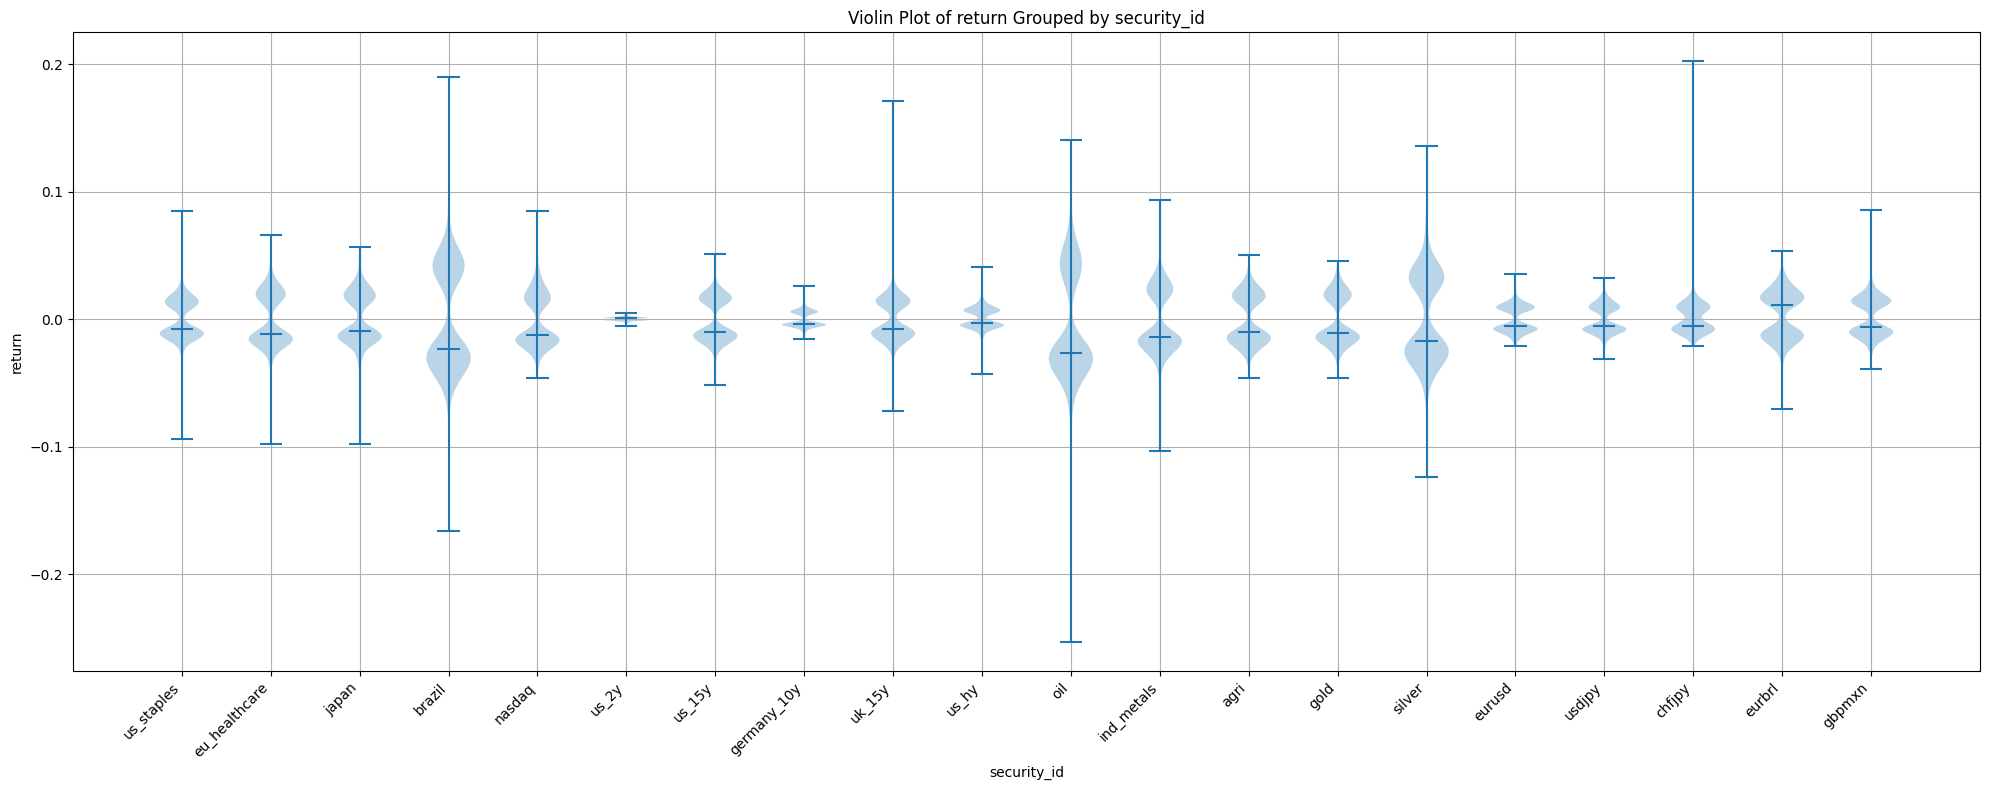

In [7]:
violin_plot_grouped(trades_list, 'security_id', 'return')

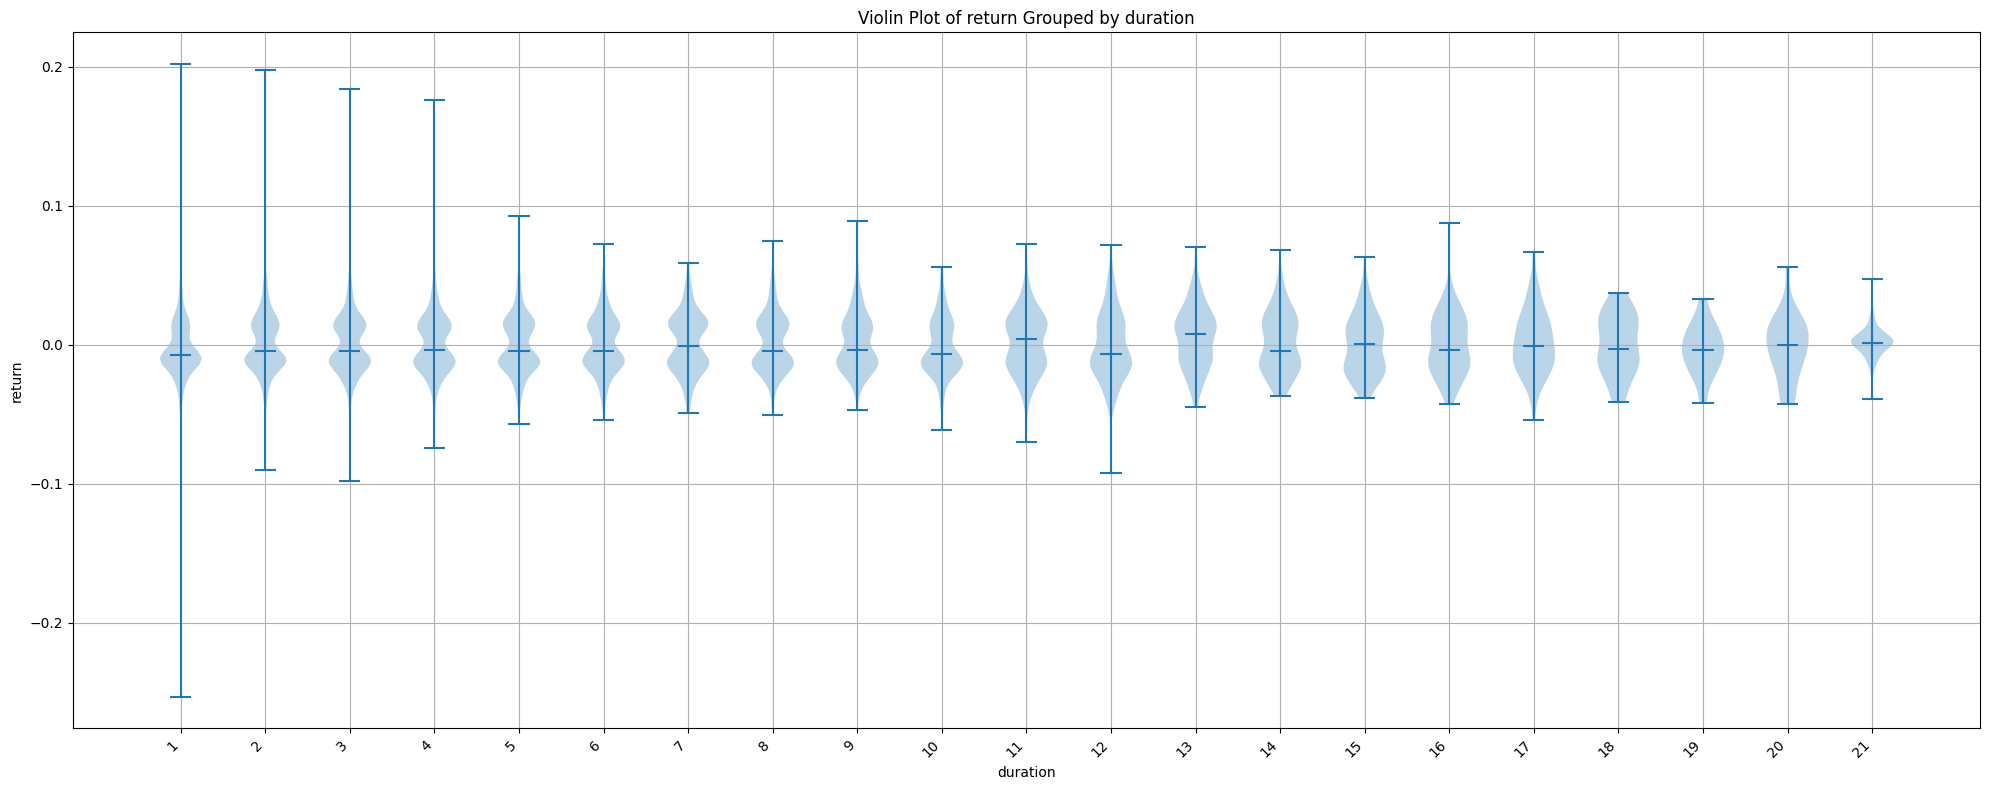

In [8]:
violin_plot_grouped(trades_list.sort_values(by='duration'), 'duration', 'return')

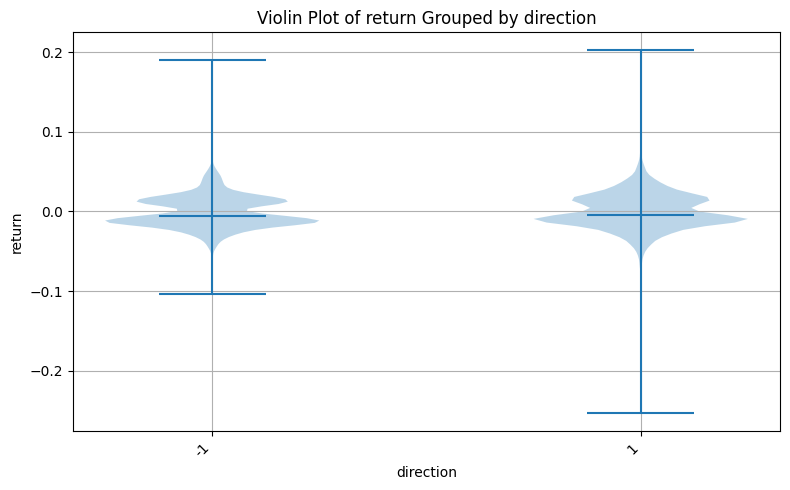

In [9]:
violin_plot_grouped(trades_list, 'direction', 'return', figsize=(8,5))

In [10]:
trades_list.groupby('security_id')['return'].describe()

,count,mean,std,min,25%,50%,75%,max
security_id,,,,,,,,
agri,576.0,-0.000302,0.019267,-0.045947,-0.015886,-0.010383,0.017942,0.050486
brazil,568.0,0.000169,0.043197,-0.166442,-0.031817,-0.023135,0.040291,0.190158
chfjpy,535.0,0.001014,0.015640,-0.021393,-0.007685,-0.005226,0.009214,0.202106
eu_healthcare,573.0,-0.000762,0.021361,-0.098154,-0.016296,-0.011579,0.019125,0.065872
eurbrl,535.0,0.002817,0.018766,-0.070436,-0.012955,0.011153,0.018015,0.053266
eurusd,536.0,0.000275,0.010311,-0.021123,-0.008028,-0.005293,0.009194,0.035495
gbpmxn,550.0,0.001604,0.014807,-0.039327,-0.010607,-0.005875,0.014321,0.085697
germany_10y,585.0,-0.000366,0.005878,-0.015643,-0.004640,-0.003522,0.005495,0.026094
gold,559.0,-0.000777,0.018973,-0.045939,-0.015206,-0.011027,0.018160,0.045609


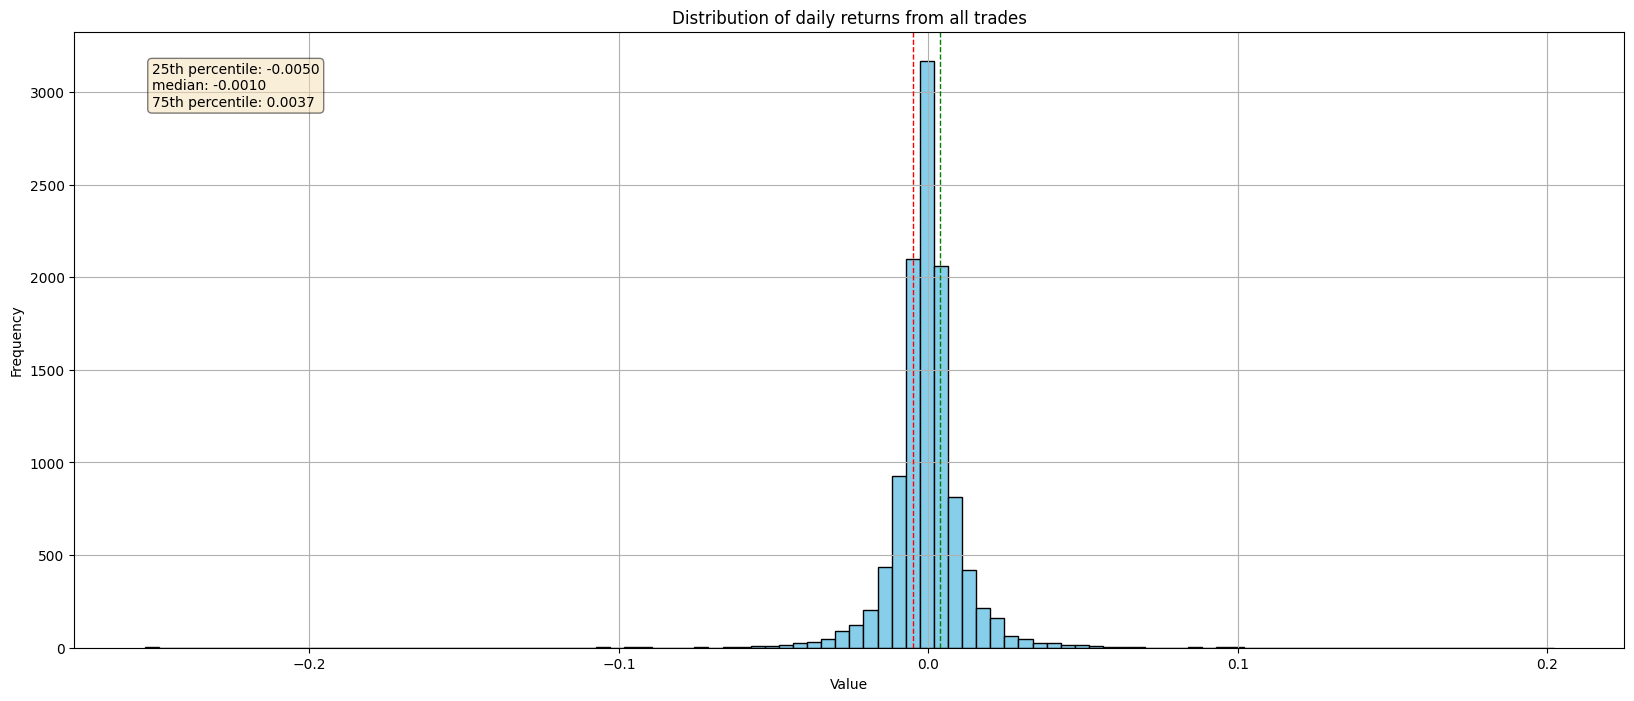

In [12]:
plot_histogram(trades_list['daily_return'], 'Distribution of daily returns from all trades', figsize=(20, 8), bins=100)

In [ ]:
trades_list['pnl'] = trades_list['price_open'] * trades_list['quantity'] * (trades_list['return'])

In [ ]:
# controlla se ha senso

gg = trades_list.groupby('security_id').apply(lambda x: x.assign(pnl_cumul = x['pnl'].cumsum())).reset_index(drop=True).sort_values(by=['security_id', 'dt_open'])

/var/folders/df/1xd3xtb5757gzbz8glj9r2000000gp/T/ipykernel_8041/586509680.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gg = trades_list.groupby('security_id').apply(lambda x: x.assign(pnl_cumul = x['pnl'].cumsum())).reset_index(drop=True).sort_values(by=['security_id', 'dt_open'])


<Axes: >

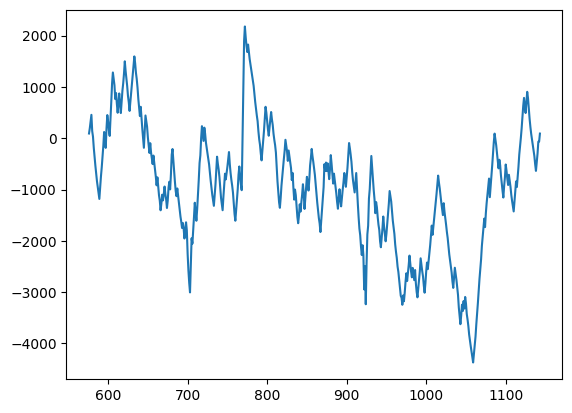

In [ ]:
vgg[gg['security_id'] == 'brazil']['pnl_cumul'].plot()

### cHeCks
using a rolling window on the price series of respectively 10, 21, 63d I compute the 5th, 15th, 25th percentiles of the distribution and I check, for the Long signal 1, if today's Price is below ALL the 5th, 15th, 25th percentiles.


In [6]:
def meanrev_signal(s,
                   long_params={10:0.05, 21:0.15, 63:0.25},
                   short_params={10:0.95, 21:0.85, 63:0.75},
                   ma_fast_wdw = 20,
                   ma_slow_wdw = 60
                   ):

    # long signal 1
    signal_long1 = pd.DataFrame()

    for k,v in long_params.items():
        signal_long1[f'qtle_px{k}'] = s.rolling(k).quantile(v)

    # signal_long1 = (s < signal_long1.min(axis=1)) * 1 

    # # short signal 1
    # signal_short1 = pd.DataFrame()

    # for k,v in short_params.items():
    #     signal_short1[f'qtle_px{k}'] = s.rolling(k).quantile(v)

    # signal_short1 = (s > signal_short1.max(axis=1)) * -1

    
    # ma_fast = s.rolling(ma_fast_wdw).mean()
    # ma_slow = s.rolling(ma_slow_wdw).mean()
    
    # # long signal 2
    # signal_long2 = ((s < ma_fast) & (s < ma_slow)) * 1
    
    # # short signal 2
    # signal_short2 = ((s > ma_fast) & (s > ma_slow)) * 1

    # # make intersection of the two signals
    # signal_long = (signal_long1 * signal_long2)
    # signal_short = (signal_short1 * signal_short2)

    # signal = signal_long + signal_short

    return signal_long1

In [9]:
meanrev_signal(df['us_staples']).tail(20)

,qtle_px10,qtle_px21,qtle_px63
dates,,,
2024-01-16,72.0820,71.22,69.105
2024-01-17,72.0820,71.22,69.310
2024-01-18,72.1225,71.52,69.465
2024-01-19,72.1445,71.85,69.535
2024-01-22,71.8575,71.85,69.615
2024-01-23,71.8575,71.88,69.770
2024-01-24,71.6395,71.88,69.925
2024-01-25,71.6395,72.01,70.035
2024-01-26,71.6395,72.03,70.130


In [17]:
df['us_staples'].tail(10)#.quantile(0.05)

dates
2024-01-30    73.46
2024-01-31    72.92
2024-02-01    74.41
2024-02-02    74.17
2024-02-05    73.71
2024-02-06    73.88
2024-02-07    73.81
2024-02-08    73.79
2024-02-09    73.11
2024-02-12    73.11
Name: us_staples, dtype: float64

In [21]:
df['us_staples'].tail(10).quantile(0.9)

74.194